<a href="https://colab.research.google.com/github/DiGyt/cateye/blob/main/example_simple_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CatEye: A Simple Introduction
_by Dirk Gütlin_

In this notebook, I will give you a quick introduction into the CatEye workflow and a simple example on how to classify  and later visualize Eyetracking data. For a quick start, you can simply click on the button above to open this notebook in Google Colab, run it, and play around as you like. For a more in-depth tutorial, check the example_pandas_workflow notebook.


First of all, we have to install the CatEye library. If you have the library already installed in your environment, you can skip this point.

In [ ]:
!pip install git+https://github.com/DiGyt/cateye.git -q

Now, let's import all the libraries we need.

In [ ]:
# import data
import numpy as np
import matplotlib.pyplot as plt

from cateye import (sfreq_to_times, classify_nslr_hmm,
                    plot_segmentation, plot_trajectory)
from cateye import sample_data_path

Let's load our data. To demonstrate how low level CatEye's data access is, we will simply work with 3 1-D arrays of equal length. One array contains the sampling times, one the x and one the y gaze coordinates. We could event work with simple Python lists here.

In [ ]:
# load the example data
data_path = sample_data_path("example_data")
data = np.genfromtxt(data_path, dtype=float, delimiter=',', names=True)
times, x, y = data["Timestamp"], data["Theta"], data["Phi"]

If we don't have a sampling times array for our data, we can create an equally spaced array from the sampling frequency (and the start time if wanted).

In [ ]:
# create a sampling times array from the sampling rate
times = sfreq_to_times(x, sfreq=119., start_time=70.5)

Let's load the events in a similar fashion. Again, we load them as simple 1-D arrays/lists.

In [ ]:
# load the event data
event_path = sample_data_path("example_events")
events = np.genfromtxt(event_path, delimiter=",", names=True, dtype=object)
event_times, event_names = events["Timestamp"], events["Name"]

Note that the event length doesn't have to match the length of our Eyetracking data. Here, it is written in what we call the "discrete" format: The event times describe annotations which occur at discrete timepoints during the course of our recording. We can always translate between the "continuous" (= matching the samples of our recording) and "discrete" format by using `cateye.discrete_to_continuous` and `cateye.continuous_to_discrete`. However, here we will keep our events in discrete format. To see why we use discrete and continuous formats, check our example_pandas_workflow.ipynb.

Let's print the first events with their description:

In [ ]:
# print the first events
print(("Timestamp", "Name"))
for row in list(zip(event_times, event_names))[:5]:
    print(row)

('Timestamp', 'Name')
(b'70.48039', b'instruction')
(b'77.00052', b'biflicker')
(b'78.51971', b'biflicker')
(b'80.03895', b'biflicker')
(b'81.55901', b'biflicker')


Let's visualize our data by plotting the X-coordinates time course while annotating the discrete events. The `cateye.plot_segmentation` function allows us to easily integrate discrete events into our plots.

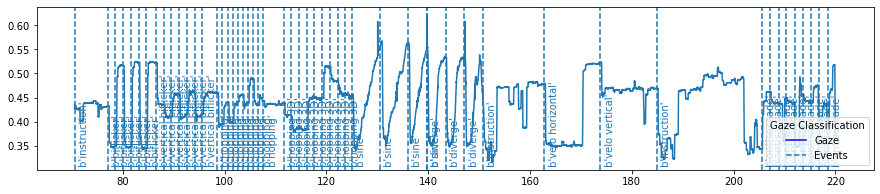

In [ ]:
# plot the phi channel of our data, with matching events
plt.figure(figsize=(15, 3))
plot_segmentation(x, times, segments=None, events=(event_times, event_names));

Now let's go ahead and apply some gaze classification on our EyeTracking. Here, we will use the [NSLR-HMM algorithm](https://gitlab.com/nslr/nslr-hmm), which can automatically classify Fixations, Saccades, Smooth Pursuits and Post-saccadic Oscillations. Note that NSLR-HMM requires the data to converted to degrees. Our current data is defined as radians, therefore we can easily convert it into the degree format using the `numpy.rad2deg` function. In order for different classifiers to work please always make sure to convert your data to the required unit.

We can return all classifier results in continuous or discrete format. Here, we will return it in discrete format again (similar to the event annotations). Additionally, we can always return the original output format of the classifier, by passing `return_orig_output=True`.

Let's print the start time and label for our first five segments after the classification.

In [ ]:
# convert the our radian data to degrees
x_deg = np.rad2deg(x)
y_deg = np.rad2deg(y)

# classify the data using NSLR-HMM
segment_id, segment_class = classify_nslr_hmm(x_deg, y_deg, times, return_discrete=True,
                                              optimize_noise=False)

# print the first classification segments
print(("Segment Times", "Prediction"))
for row in list(zip(segment_id, segment_class))[:5]:
    print(row)

('Segment Times', 'Prediction')
(70.5, 'PSO')
(70.50840336134453, 'Fixation')
(70.59243697478992, 'Fixation')
(70.60924369747899, 'Fixation')
(70.79411764705883, 'Smooth Pursuit')


/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/nslr_hmm/nslr_hmm.py:301: RuntimeWarning: invalid value encountered in true_divide
  direction = speed/velocity


Let's visualize NSLR's classification using our `plot_segmentation` function. This time, we won't pass the discrete event markers, but instead colour different segments of the time course according to the predicted class.

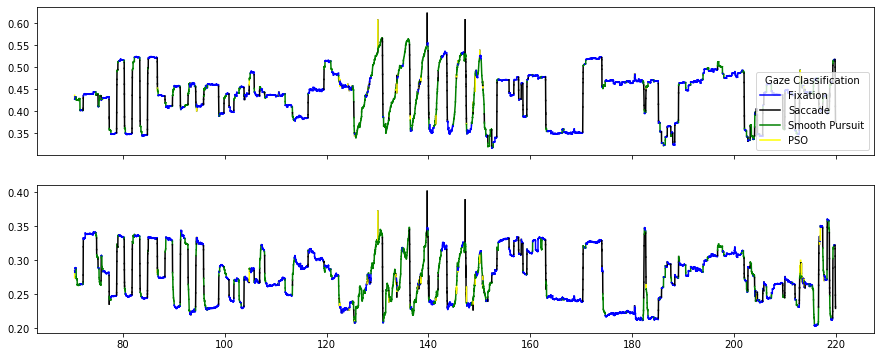

In [ ]:
# Join segment IDs and classes as a tuple for understanding
classification = (segment_id, segment_class)

# plot the classification results
fig, axes = plt.subplots(2, figsize=(15, 6), sharex=True)
plot_segmentation(x, times, segments=classification, events=None, ax=axes[0])
plot_segmentation(y, times, segments=classification, events=None, ax=axes[1],
                  show_legend=False);

CatEye also provides a plotting function for visualizing the eve movement trajectory. Similar to the `cateye.plot_segmentation` function, we can color single segments of our trajectory with the corresponding label color.

For clearer visualization, we will only plot the first 900 samples of our data.

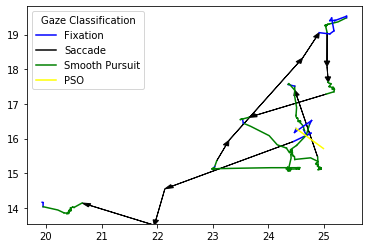

In [ ]:
# plot trajectory
plot_trajectory(x_deg[:900], y_deg[:900], times[:900], classification);